In [6]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# df = pd.read_csv('collision_data_prepared.csv')
df = pd.read_csv('sample_dataset.csv')

In [24]:
df.head()

,one_hot_encoder__borough_bronx,one_hot_encoder__borough_brooklyn,one_hot_encoder__borough_manhattan,one_hot_encoder__borough_queens,one_hot_encoder__borough_staten island,one_hot_encoder__season_Fall,one_hot_encoder__season_Spring,one_hot_encoder__season_Summer,one_hot_encoder__season_Winter,one_hot_encoder__contributing factor vehicle 1_backing unsafely,...,one_hot_encoder__vehicle class_buses,one_hot_encoder__vehicle class_heavy-duty vehicles,one_hot_encoder__vehicle class_motorcycles & bikes,one_hot_encoder__vehicle class_passenger cars,remainder__year,remainder__month,remainder__day,remainder__hour,street tier,level_of_severity
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2022,5,24,16,0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,2017,4,19,11,2,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2014,10,22,4,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2015,3,11,9,1,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2017,8,17,17,0,0


In [40]:
# df.iloc[0]

## Ideas

In [29]:
# objectives:
# **Dealing with Class Imbalance**
#    - Resampling Techniques (Oversampling, Undersampling, SMOTE, etc.)
#    - OR Cost-sensitive Learning

# **Model Selection and Development**
#    - Choose Suitable Algorithms
#    - Hyperparameter Tuning with Cross-Validation

# **Validation Strategy**
#    - Implement K-Fold Cross-Validation
#      - Stratify Folds for Imbalanced Data
#    - Consider Repeated Cross-Validation for Robustness

# **Performance Evaluation**
#    - Use Appropriate Metrics (Precision, Recall, F1, ROC-AUC, PR curves)
#    - Model Interpretation (Feature Importance, SHAP Values)

# **Post-Processing**
#    - Threshold Adjustment for Decision Making

# **Model Deployment and Monitoring**
#    - Deploy Model with Scaling Considerations
#    - Monitor Performance for Data Drift and Degradation

In [8]:
# algorithms going to use:
# 1. logistic regression
# 2. decision tree classifier
# 3. k-nn
# 4. random forest
# 5. naive bayes
# 6. xgboost
# 

In [9]:
# In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, 
# and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’.
# (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

# we can try 'lbfgs', and 'saga' in this model

# for cross validation: common values are k=5, k=10, and k=20. (10 or 20 are better for large dataset)

# The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
# ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.

# for parameter tunning:
# we also need to find the optimal hyperparameter 'C'
# 'lbfgs': The default solver as of scikit-learn 0.22. It supports only L2 regularization or no regularization. It's a good choice for most cases, 
# especially for multiclass problems and when the number of samples is larger than the number of features.

# Building Machine Learning Model

In [22]:
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, classification_report

In [25]:
# Define features (X) and target variable (y)
X = df.drop('level_of_severity', axis=1)
y = df['level_of_severity']

# Apply SMOTE to the training set to handle class imbalance
smote_tomek = SMOTETomek(random_state=101)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 7180), (1, 7180)]


In [26]:
# split the dataset (use most commmon split 0.2 or 0.3)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=101)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_test.shape)

Training set shape: (10052, 27)
Validation set shape: (4308, 27)


In [35]:
def eval_metrics(model, X_test, y_test):
    """
    Evaluate a trained machine learning model on the given test data and labels.
    
    Parameters:
        model: Trained model implementing the scikit-learn estimator interface.
        X_test: Test features.
        y_test: True labels for the test data.
        
    Outputs:
        Prints the best parameters, AUC score, F1 score, confusion matrix, and classification report.
    """
    # Output the best parameters and best AUC score from grid search
    print("Best Parameters:", model.best_params_)
    print("Best AUC Score:", model.cv_results_['mean_test_AUC'].max())
    
    # Predict classes and class probabilities on the test set
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
    # Calculate F1 score and AUC for the test set
    test_f1 = f1_score(y_test, y_pred, average='macro')
    test_auc = roc_auc_score(y_test, y_probs)
    
    # Print evaluation metrics
    print("Test F1 Macro Score:", test_f1)
    print("Test AUC Score:", test_auc)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

## Logistic Regression

In [15]:
# Create a pipeline of logistic regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])

lr_param_grid = {
    'classifier__C': np.logspace(0, 4, 10), # Regularization for logistic regression
    'classifier__penalty':['l1','l2']
}

lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,  # Number of folds
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Scoring metric
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1  # Use all available cores
)

lr_grid_search.fit(X_train, y_train)

eval_metrics(lr_grid_search, X_test, y_test)

Best Parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1'}
Best AUC Score: 0.6836261289033367
Test F1 Macro Score: 0.6289585677881693
Test AUC Score: 0.6847239464790675
Confusion Matrix:
 [[1319  841]
 [ 757 1391]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      2160
           1       0.62      0.65      0.64      2148

    accuracy                           0.63      4308
   macro avg       0.63      0.63      0.63      4308
weighted avg       0.63      0.63      0.63      4308



## Decision Tree (Classifier)

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
# Create a pipeline of Decision Tree
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=101))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, None],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

dt_grid_search = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=5,  # Number of folds
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Scoring metric
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to the training data
dt_grid_search.fit(X_train, y_train)

eval_metrics(dt_grid_search, X_test, y_test)

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best AUC Score: 0.8294481507635585
Test F1 Macro Score: 0.7551603594334257
Test AUC Score: 0.8224551046623904
Accuracy: 0.7581244196843082
Confusion Matrix:
 [[1870  290]
 [ 752 1396]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      2160
           1       0.83      0.65      0.73      2148

    accuracy                           0.76      4308
   macro avg       0.77      0.76      0.76      4308
weighted avg       0.77      0.76      0.76      4308



## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# Define the column transformer: only apply MinMaxScaler to continuous features
preprocessor = ColumnTransformer(
    transformers=[
        ('normalize', MinMaxScaler(), ['remainder__year', 'remainder__month', 'remainder__day', 'remainder__hour'])
    ],
    remainder='passthrough'  # Leave all other columns untransformed
)

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
    ])

# Define the parameter grid for KNN
knn_param_grid = {
    'classifier__n_neighbors': [5],  # Number of neighbors to use
    'classifier__weights': ['uniform', 'distance'],  # Weighting function for prediction
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute the nearest neighbors
    'classifier__p': [1, 2]  # Power parameter for the Minkowski metric (1=manhattan_distance, 2=euclidean_distance)
}

knn_grid_search = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=5,
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Scoring metric
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1
)

# Fit the grid search to the training data
knn_grid_search.fit(X_train, y_train)

eval_metrics(knn_grid_search, X_test, y_test)

Best Parameters: {'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best AUC Score: 0.7882789830331619
Test F1 Macro Score: 0.7267772550318355
Test AUC Score: 0.8041001750120699
Confusion Matrix:
 [[1709  451]
 [ 721 1427]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2160
           1       0.76      0.66      0.71      2148

    accuracy                           0.73      4308
   macro avg       0.73      0.73      0.73      4308
weighted avg       0.73      0.73      0.73      4308



## Ramdom Forest (Classifier)

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Create a pipeline with scaling and Random Forest classifier
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=101))
])

# Define the parameter grid for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'classifier__max_depth': [10, 20, 30, 35, 40],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'classifier__max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

# Set up the grid search with Random Forest-specific parameters
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,  # Number of folds
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Scoring metric
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

eval_metrics(rf_grid_search, X_test, y_test)

Best Parameters: {'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Best AUC Score: nan
Test F1 Macro Score: 0.7932682166897045
Test AUC Score: 0.8723950789709636
Accuracy: 0.7957288765088208
Confusion Matrix:
 [[1949  211]
 [ 669 1479]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.82      2160
           1       0.88      0.69      0.77      2148

    accuracy                           0.80      4308
   macro avg       0.81      0.80      0.79      4308
weighted avg       0.81      0.80      0.79      4308



## XGBoost

In [22]:
# !pip install xgboost

In [13]:
import xgboost as xgb

In [15]:
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=101)


param_grid = {
    'max_depth': [12, 20, 40],
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(
    xgb_classifier,
    param_grid,
    cv=5,  # Number of folds
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Use a dictionary to specify multiple metrics
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

eval_metrics(grid_search, X_test, y_test)

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 40, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best AUC Score: 0.8849238276234024
Test F1 Macro Score: 0.8001933039172375
Test AUC Score: 0.8691248103317469
Accuracy: 0.8010677808727948
Confusion Matrix:
 [[1868  292]
 [ 565 1583]]
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2160
           1       0.84      0.74      0.79      2148

    accuracy                           0.80      4308
   macro avg       0.81      0.80      0.80      4308
weighted avg       0.81      0.80      0.80      4308



In [29]:
rfe_f1_score = []

for k in range(1, 28):
    RFE_selector = RFE(estimator=xgb_classifier, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train, y_train)
    
    sel_X_train = RFE_selector.transform(X_train)
    sel_X_test = RFE_selector.transform(X_test)
    
    xgb_classifier.fit(sel_X_train, y_train)
    RFE_preds = xgb_classifier.predict(sel_X_test)
    
    f1_score_rfe = round(f1_score(y_test, RFE_preds, average='weighted'), 3)
    
    rfe_f1_score.append(f1_score_rfe)

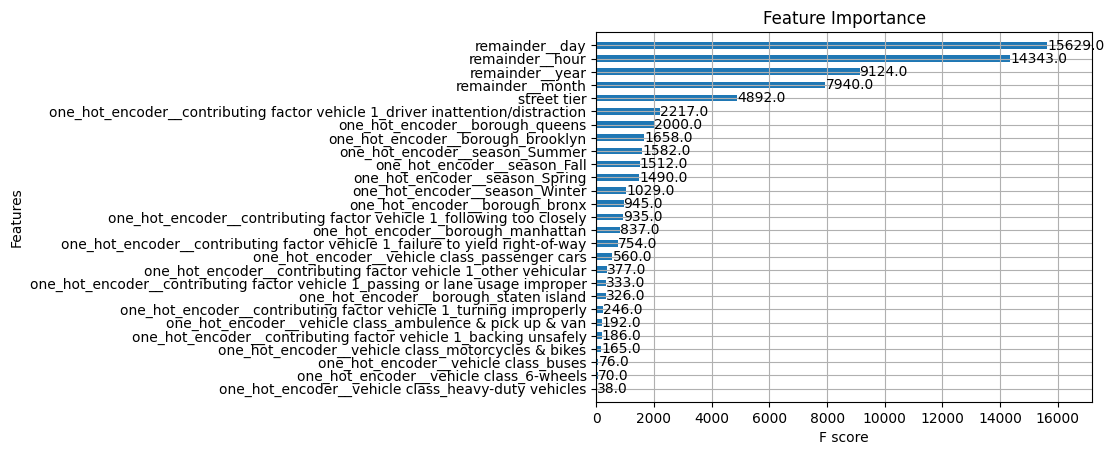

In [16]:
# Access the best estimator's classifier
best_classifier = grid_search.best_estimator_.named_steps['classifier']
# Accessing the underlying booster of the XGBClassifier if needed
booster = best_classifier.get_booster()
# Plotting feature importance
xgb.plot_importance(booster, importance_type='weight', title='Feature Importance', height=0.5)
plt.show()

## Naive Bayes

In [21]:
from sklearn.naive_bayes import CategoricalNB

In [18]:
# Create a pipeline with Categorical Naive Bayes classifier
cnb_pipeline = Pipeline([
    ('classifier', CategoricalNB(min_categories=2))  # Initialize CategoricalNB, min_categories can be adjusted
])

# Define the parameter grid for CategoricalNB
cnb_param_grid = {
    'classifier__alpha': [1.0, 0.5, 0.1, 0.01],  # Additive (Laplace/Lidstone) smoothing parameter
    'classifier__fit_prior': [True, False]  # Whether to learn class prior probabilities or not.
}

# Set up the grid search with CategoricalNB-specific parameters
cnb_grid_search = GridSearchCV(
    cnb_pipeline,
    cnb_param_grid,
    cv=5,  # Number of folds
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},  # Use a dictionary to specify multiple metrics
    refit='AUC',  # Choose which scorer to use to find the best parameters
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
cnb_grid_search.fit(X_train, y_train)

eval_metrics(cnb_grid_search, X_test, y_test)

Best Parameters: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
Best AUC Score: 0.8228908312843654
Test F1 Macro Score: 0.7397762221257685
Test AUC Score: 0.8107927701910476
Accuracy: 0.739786443825441
Confusion Matrix:
 [[1580  580]
 [ 541 1607]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      2160
           1       0.73      0.75      0.74      2148

    accuracy                           0.74      4308
   macro avg       0.74      0.74      0.74      4308
weighted avg       0.74      0.74      0.74      4308



## Support Vector Machine (SVM)

In [29]:
# !pip install scikit-learn-intelex

In [30]:
from sklearnex import patch_sklearn 
patch_sklearn() # Decrease the computational time
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [1]:
# # Create a pipeline with Support Vector Machine (C-support Vector Classification)
# svm_pipeline = Pipeline([
#     ('scaler', StandardScaler()), # SVM benefits from feature scaling
#     ('classifier', SVC(random_state=42))
# ])

# # Define the parameter grid for SVM
# svm_param_grid = {
#     'classifier__C': [0.1, 1, 10],  # Regularization parameter
#     'classifier__kernel': ['rbf'],  # Type of SVM kernel
#     # 'classifier__degree': [1, 2, 3],  # Degree for the polynomial kernel, if 'poly' is used
#     # 'classifier__gamma': ['scale', 'auto', 0.1, 1] # Kernel coefficient
# }

# # Set up the grid search with SVM-specific parameters
# svm_grid_search = GridSearchCV(
#     svm_pipeline,
#     svm_param_grid,
#     cv=5,  # Number of folds
#     scoring=make_scorer(f1_score, average='macro'),  # Scoring metric
#     n_jobs=-1  # Use all available cores
# )

# # Fit the grid search to the training data
# svm_grid_search.fit(X_train, y_train)

# eval_metrics(svm_grid_search, X_test, y_test)

## CatBoost

In [31]:
# !pip install catboost

In [32]:
from catboost import CatBoostClassifier

In [33]:
cb_pipeline = Pipeline([
    ('classifier', CatBoostClassifier(verbose=0, random_seed=101))
])

# Define the parameter grid
cb_param_grid = {
    'classifier__depth': [6, 8, 10],  # Equivalent to max_depth in other GBMs
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__n_estimators': [200, 300, 400],
    'classifier__subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instance
}

# Set up the grid search
cb_grid_search = GridSearchCV(
    cb_pipeline,
    cb_param_grid,
    cv=5,
    scoring={'AUC': 'roc_auc', 'F1': make_scorer(f1_score, average='macro')},
    refit='AUC',
    n_jobs=-1
)

# Fit the grid search
cb_grid_search.fit(X_train, y_train)

# Evaluate metrics function needs to be previously defined or implemented here
eval_metrics(cb_grid_search, X_test, y_test)

Best Parameters: {'classifier__depth': 10, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best AUC Score: 0.882943059408045
Test F1 Macro Score: 0.797368674899823
Test AUC Score: 0.868801081109042
Confusion Matrix:
 [[1913  247]
 [ 619 1529]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2160
           1       0.86      0.71      0.78      2148

    accuracy                           0.80      4308
   macro avg       0.81      0.80      0.80      4308
weighted avg       0.81      0.80      0.80      4308

